### Using Pandas DataFrames to store SQL results

In [1]:
import pymysql
import sys
import pandas as pd

In [2]:
host = 'localhost'
username = 'root'
password = ''
database = 'imdb'

connection = pymysql.connect(host, username, password, database, charset='utf8', use_unicode=True);
with connection:
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute("SELECT * FROM actors;")
    actors = cursor.fetchall()

In [3]:
actors[:3]

[{'first_name': 'Michael',
  'gender': 'M',
  'id': 2,
  'last_name': "'babeepower' Viera"},
 {'first_name': 'Eloy', 'gender': 'M', 'id': 3, 'last_name': "'Chincheta'"},
 {'first_name': 'Dieguito',
  'gender': 'M',
  'id': 4,
  'last_name': "'El Cigala'"}]

In [4]:
# pandas can create a DataFrame from the list of dictionaries
df_actors = pd.DataFrame(actors)
df_actors.head()

,first_name,gender,id,last_name
0,Michael,M,2,'babeepower' Viera
1,Eloy,M,3,'Chincheta'
2,Dieguito,M,4,'El Cigala'
3,Antonio,M,5,'El de Chipiona'
4,José,M,6,'El Francés'


In [5]:
# We can specify that the "id" column is the primary key for the table
df_actors.set_index(keys="id", inplace=True)
df_actors.head()

,first_name,gender,last_name
id,,,
2,Michael,M,'babeepower' Viera
3,Eloy,M,'Chincheta'
4,Dieguito,M,'El Cigala'
5,Antonio,M,'El de Chipiona'
6,José,M,'El Francés'


In [6]:
df_actors["first_name"].describe()

count     817718
unique    110004
top         John
freq        4371
Name: first_name, dtype: object

In [7]:
#get top 10 most popular female names
df_actors["first_name"][df_actors['gender']=='F'].value_counts()[:10]

Maria       1682
Anna        1612
Barbara     1363
Mary        1263
Laura       1240
Lisa        1226
Jennifer    1135
Susan       1116
Anne        1086
Marie        987
Name: first_name, dtype: int64

### Exercise:

Find 15 most popular lastnames for Male actors

In [8]:
# your code is here
df_actors["last_name"][df_actors['gender']=='M'].value_counts()[:15]

Smith       1608
Williams    1151
Jones       1115
Johnson     1045
Lee         1020
Brown        984
Miller       823
Davis        762
Wilson       714
Martin       705
Taylor       703
Thomas       666
Anderson     610
Scott        589
White        581
Name: last_name, dtype: int64

### Additional Examples with SQL and Pandas

In [9]:
# A little bit of setup code, just to make the plots look better
import matplotlib.pyplot as plt
%matplotlib inline
# Make the graphs a bit prettier, and bigger
plt.rcParams['figure.figsize'] = (15, 5)

Now let's run a query to get the political views of Facebook users, broken down by gender.

In [10]:
host = 'localhost'
username = 'root'
password = ''
database = 'facebook'

polviews_by_gender = '''
SELECT Sex, `Political Views` AS PoliticalViews, COUNT(*) AS cnt
FROM Profiles
WHERE Sex IS NOT NULL AND `Political Views` IS NOT NULL
GROUP BY Sex, `Political Views`
ORDER BY  `Political Views`, Sex'''


connection = pymysql.connect(host, username, password, database, charset='utf8', use_unicode=True);
with connection:
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(polviews_by_gender)
    response = cursor.fetchall()

And let's get the dataframe:

In [11]:
df = pd.DataFrame(response)
df.head()

,PoliticalViews,Sex,cnt
0,Apathetic,Female,309
1,Apathetic,Male,462
2,Conservative,Female,428
3,Conservative,Male,474
4,Liberal,Female,4054


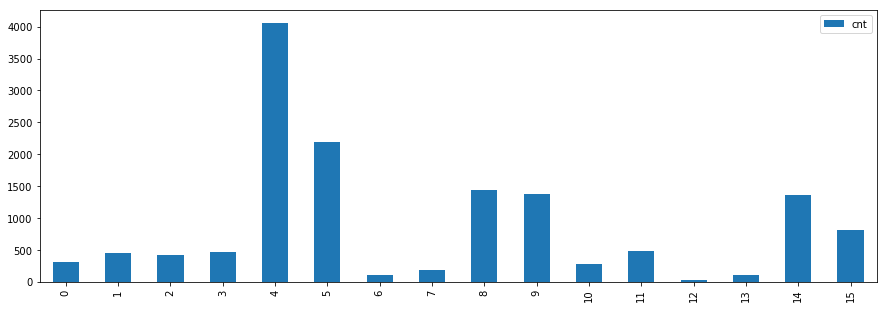

In [12]:
# Let's plot this!
# Bleh, this is really fugly...
df.plot(kind='bar')

## Pivot table!

In [13]:
dfp = df.pivot(index='PoliticalViews', columns='Sex', values='cnt')
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,309,462
Conservative,428,474
Liberal,4054,2196
Libertarian,113,196
Moderate,1444,1379
Other,280,482
Very Conservative,38,107
Very Liberal,1362,813


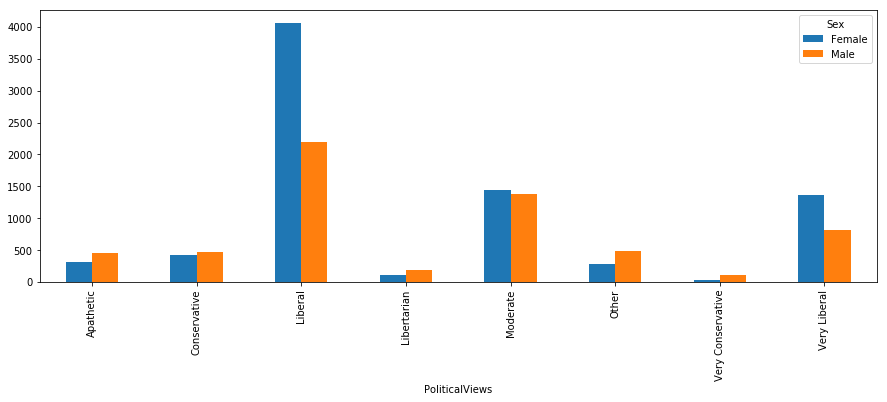

In [14]:
dfp.plot(kind='bar')

In [15]:
# Let's normalize the columns, as we have more females than males, and it seems that there are always more women
dfp["Female"] = dfp["Female"]/sum(dfp["Female"])
dfp["Male"] = dfp["Male"]/sum(dfp["Male"])
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,0.038490,0.075626
Conservative,0.053313,0.077590
Liberal,0.504983,0.359470
Libertarian,0.014076,0.032084
Moderate,0.179870,0.225733
Other,0.034878,0.078900
Very Conservative,0.004733,0.017515
Very Liberal,0.169656,0.133082


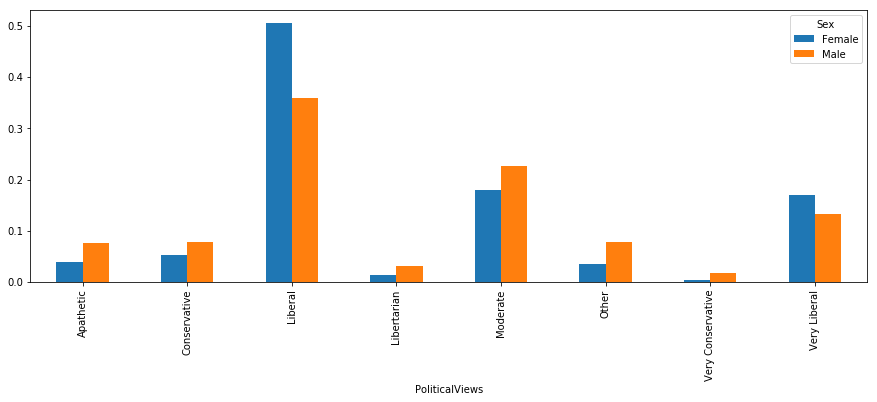

In [16]:
dfp.plot(kind='bar')

In [20]:
# OK, now let's try to re-order the list of results according to the logical structure
neworder = ['Very Liberal', 'Liberal', 'Moderate', 'Conservative', 'Very Conservative', 'Libertarian', 'Apathetic', 'Other']
newindex = sorted(dfp.index, key=lambda x: neworder.index(x))
dfp = dfp.reindex(newindex)
dfp

Sex,Female,Male
PoliticalViews,,
Very Liberal,0.169656,0.133082
Liberal,0.504983,0.359470
Moderate,0.179870,0.225733
Conservative,0.053313,0.077590
Very Conservative,0.004733,0.017515
Libertarian,0.014076,0.032084
Apathetic,0.038490,0.075626
Other,0.034878,0.078900


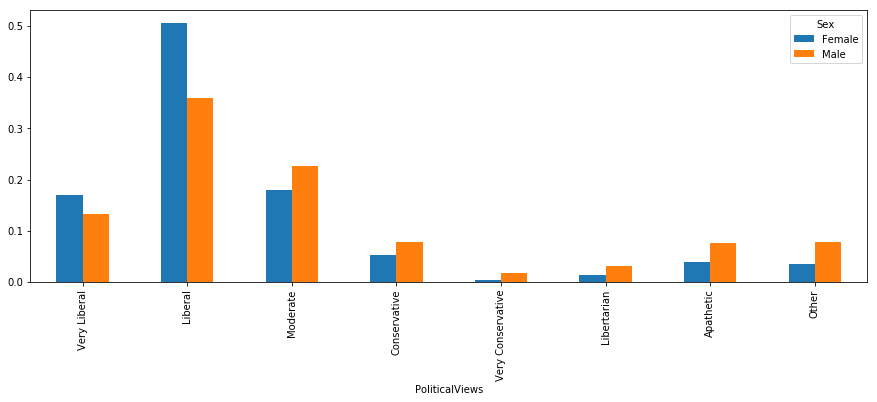

In [21]:
dfp.plot(kind='bar')

### Facebook, Favorite Books, and Political views

In [22]:
host = 'localhost'
username = 'root'
password = ''
database = 'facebook'

books_sql = '''
SELECT F.FavoriteBook, P.`Political Views` AS PoliticalViews, COUNT(*) AS cnt \
FROM Profiles P JOIN FavoriteBooks F ON F.ProfileID = P.ProfileId  \
WHERE `Political Views` IS NOT NULL AND F.FavoriteBook IS NOT NULL \
GROUP BY F.FavoriteBook, P.`Political Views`'''


connection = pymysql.connect(host, username, password, database, charset='utf8', use_unicode=True);
with connection:
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(books_sql)
    books = cursor.fetchall()

In [23]:
df_books = pd.DataFrame(books, columns=books[0].keys())
df_books.head(10)

,FavoriteBook,PoliticalViews,cnt
0,000 In College Loans And A Meaningless Diploma...,Liberal,1
1,000 Leagues Under The Sea,Liberal,2
2,000 Leagues Under The Sea,Very Liberal,2
3,000 Places To See Before You Die,Apathetic,1
4,000 Things To Be Happy About,Liberal,1
5,1,Apathetic,1
6,1,Liberal,1
7,1 3 Of Whatever Is Currently On Each Class Syl...,Moderate,1
8,1 Bachelorette,Liberal,1
9,1 Fish 2 Fish Red Fish Blue Fish,Moderate,1


In [24]:
# Pivot table.
dfp = df_books.pivot(index='FavoriteBook', columns='PoliticalViews', values='cnt')
dfp.head(10)

PoliticalViews,Apathetic,Conservative,Liberal,Libertarian,Moderate,Other,Very Conservative,Very Liberal
FavoriteBook,,,,,,,,
000 In College Loans And A Meaningless Diploma Quot,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
000 Leagues Under The Sea,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0
000 Places To See Before You Die,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000 Things To Be Happy About,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1 3 Of Whatever Is Currently On Each Class Syllabus,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1 Bachelorette,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1 Fish 2 Fish Red Fish Blue Fish,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1 Timothy And 2 Timothy,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [25]:
# We will normalize the columns
import numpy as np

for politival_view in dfp.columns:
    print(politival_view, np.nansum(dfp[politival_view]))
    dfp[politival_view] = dfp[politival_view] / np.nansum(dfp[politival_view])
    
dfp

Apathetic 2881.0
Conservative 3318.0
Liberal 31253.0
Libertarian 1593.0
Moderate 12173.0
Other 3772.0
Very Conservative 627.0
Very Liberal 12630.0


PoliticalViews,Apathetic,Conservative,Liberal,Libertarian,Moderate,Other,Very Conservative,Very Liberal
FavoriteBook,,,,,,,,
000 In College Loans And A Meaningless Diploma Quot,NaN,NaN,0.000032,NaN,NaN,NaN,NaN,NaN
000 Leagues Under The Sea,NaN,NaN,0.000064,NaN,NaN,NaN,NaN,0.000158
000 Places To See Before You Die,0.000347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000 Things To Be Happy About,NaN,NaN,0.000032,NaN,NaN,NaN,NaN,NaN
1,0.000347,NaN,0.000032,NaN,NaN,NaN,NaN,NaN
1 3 Of Whatever Is Currently On Each Class Syllabus,NaN,NaN,NaN,NaN,0.000082,NaN,NaN,NaN
1 Bachelorette,NaN,NaN,0.000032,NaN,NaN,NaN,NaN,NaN
1 Fish 2 Fish Red Fish Blue Fish,NaN,NaN,NaN,NaN,0.000082,NaN,NaN,NaN
1 Timothy And 2 Timothy,NaN,NaN,NaN,NaN,0.000082,NaN,NaN,NaN


In [26]:
#Let's calculate some indexes
dfp["Liberal_To_Conservative"] = (dfp["Liberal"] + dfp["Very Liberal"]) / (dfp["Conservative"] + dfp["Very Conservative"])
dfp["Conservative_To_Liberal"] = (dfp["Conservative"] + dfp["Very Conservative"]) / (dfp["Liberal"] + dfp["Very Liberal"])

In [27]:
# dfp.sort_values("Liberal_To_Conservative", ascending=False)
dfp[["Liberal_To_Conservative"]].sort_values("Liberal_To_Conservative", ascending=False).head(50)

PoliticalViews,Liberal_To_Conservative
FavoriteBook,
One Hundred Years Of Solitude,2.831502
The Bell Jar,2.635832
On The Road,2.124912
Catch 22,1.866950
The Perks Of Being A Wallflower,1.786482
Lolita,1.763747
Franny And Zooey,1.749649
America The Book,1.556607
The Stranger,1.552559


In [28]:
dfp[["Conservative_To_Liberal"]].sort_values("Conservative_To_Liberal", ascending=False).head(10)

PoliticalViews,Conservative_To_Liberal
FavoriteBook,
Liar S Poker,42.689381
War And Peace,17.873188
The Apology,17.056968
C S Lewis,15.350022
The Idiot,14.911170
Mere Christianity,14.229794
Republic,13.244934
All The Kings Men,13.244934
Exodus,12.594917


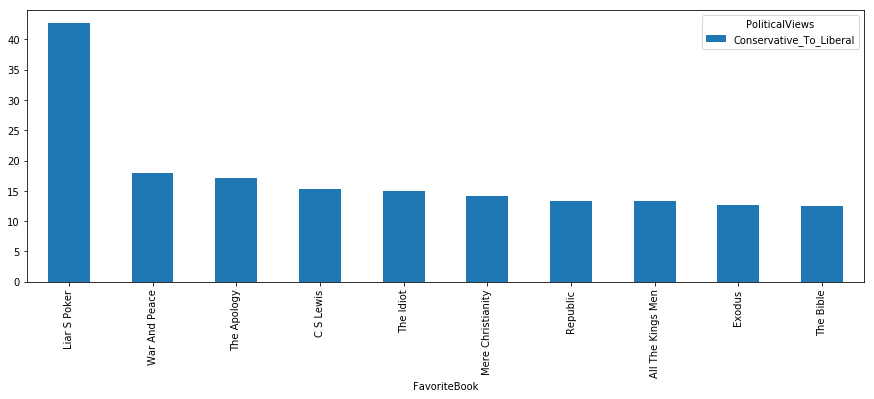

In [29]:
dfp[["Conservative_To_Liberal"]].sort_values("Conservative_To_Liberal", ascending=False).head(10).plot(kind='bar')

## Exercise

Find the top 10 "male" books and top 10 "fremale" books. 

In [30]:
#your code is here
host = 'localhost'
username = 'root'
password = ''
database = 'facebook'

books_sql = '''
SELECT F.FavoriteBook, P.Sex AS sex, COUNT(*) AS cnt \
FROM Profiles P JOIN FavoriteBooks F ON F.ProfileID = P.ProfileId  \
WHERE sex IS NOT NULL AND F.FavoriteBook IS NOT NULL \
GROUP BY F.FavoriteBook, P.sex'''


connection = pymysql.connect(host, username, password, database, charset='utf8', use_unicode=True);
with connection:
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(books_sql)
    books = cursor.fetchall()

df_books = pd.DataFrame(books, columns=books[0].keys())
df_books.head(10)



,FavoriteBook,sex,cnt
0,0,Male,1
1,000 In College Loans And A Meaningless Diploma...,Male,1
2,000 Leagues Under The Sea,Female,1
3,000 Leagues Under The Sea,Male,3
4,000 Places To See Before You Die,Female,1
5,000 Things To Be Happy About,Male,1
6,087 Penguin Classics Now Available To My Mothe...,Female,1
7,1,Female,2
8,1,Male,1
9,1 3 Of Whatever Is Currently On Each Class Syl...,Female,1


In [31]:
dfp = df_books.pivot(index='FavoriteBook', columns='sex', values='cnt')
dfp["Female_to_Male"] = (dfp["Female"]) / (dfp["Male"])
dfp["Male_to_Female"] = (dfp["Male"]) / (dfp["Female"])

In [32]:
dfp[["Male_to_Female"]].sort_values("Male_to_Female", ascending=False).head(10)

sex,Male_to_Female
FavoriteBook,
When Genius Failed,21.0
Battle Royale,14.0
Maxim,13.0
Liars Poker,13.0
Ugly Americans,12.0
Neuromancer,11.0
Gq,11.0
Barbarians At The Gate,10.0
Art Of War,10.0


In [33]:
dfp[["Female_to_Male"]].sort_values("Female_to_Male", ascending=False).head(10)

sex,Female_to_Male
FavoriteBook,
Bergdorf Blondes,79.000000
White Oleander,72.000000
She S Come Undone,36.666667
Little Women,34.333333
My Sister S Keeper,33.000000
Gone With The Wind,30.250000
Anne Of Green Gables,30.000000
The Secret Life Of Bees,27.500000
Nanny Diaries,27.000000
